In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import numpy as np
import os
from glob import glob
from PIL import Image
import cv2
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [2]:
data_dir = '/home/seercv/facenet_assets/test_a'

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

resnet = InceptionResnetV1(
    classify=False,
    pretrained=None,
    num_classes=len(os.listdir(data_dir)))

resnet.to(device)
checkpoint = torch.load('../models/test.pt')
resnet.load_state_dict(checkpoint['model_state_dict'])
_ = resnet.eval()

Running on device: cuda:0


In [3]:
def load_aligned(path):
    img_a = cv2.imread(path, 1)
    img_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2RGB).transpose((2,0,1))
    img_a_tensor = torch.from_numpy(img_a).float().to(device).unsqueeze(0)
    img_a_tensor = fixed_image_standardization(img_a_tensor)
    emb_tensor = resnet(img_a_tensor)
    emb_a = emb_tensor.detach().cpu().numpy().squeeze()
    return emb_a

In [4]:
imgs = glob('/home/seercv/facenet_assets/seer_a/**', recursive=True)
imgs = [x for x in imgs if '.png' in x]

X = []
y = []

for path in imgs:
    label = path.split('seer_a/')[-1].split('/')[0]
    emb = load_aligned(path)
    X.append(emb)
    y.append(label)

le = LabelEncoder()

X = np.array(X, dtype=np.float32)
y = le.fit_transform(y)
labels = le.classes_

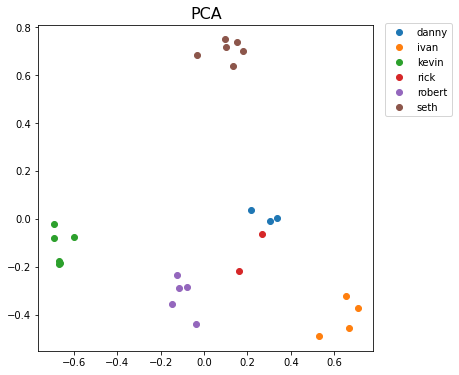

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
for i in range(len(np.unique(y))):
    ax.scatter(X_pca[y==i,0], X_pca[y==i,1], label=labels[i])
plt.title('PCA', size=16)
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.02))
plt.show()

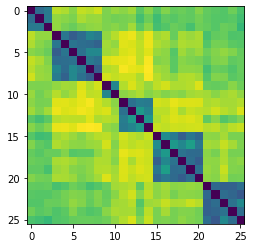

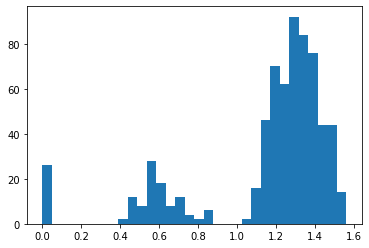

In [6]:
dists = euclidean_distances(X)
plt.imshow(dists)
plt.show()
plt.hist(dists.flatten(), bins='auto')
plt.show()